In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import torch
import torch.nn as nn

In [3]:
g = 9.81 # m/s^2
m = 0.16 # kg
r = 0.036 # m
pi = np.pi
A = pi*r*r # m^2
rho = 1.225 # kg/m^3
C = 0.5*rho*A/m # 1/m
Cd = 0.5 # nondim
Cs = 0.3 # nondim
L = 20.12 - 1.22 # m; pitch length - crease length
RCD = 1.83 #m, Return crease distance from stumps
SH = 0.71 # m; stumps height
SW = 0.2286 # m; stumps width
MR = 2.5  # m; maxm vertical release
deg2rad = pi/180.0
kmph2mps = 0.277778

In [4]:
def get_position(release,theta,LDS ,SHD, AL):
  xs = torch.zeros(3, dtype=torch.float32)
  xs[0] = (AL)*torch.sin(release)
  xs[1] = LDS + (AL)*torch.cos(release)*torch.sin(theta)
  xs[2] = SHD + (AL)*torch.cos(release)*torch.cos(theta)
  return xs

def get_velocity(release, theta, speed):
  vs = torch.zeros(3, dtype=torch.float32)
  vs[0] = speed*torch.cos(release)
  vs[1] = -speed*torch.sin(release)*torch.sin(theta)
  vs[2] = -speed*torch.sin(release)*torch.cos(theta)
  return vs

def f_traj(u, v, w, windspeed):
  fs = torch.zeros(3)
  v_norm = torch.sqrt((u - windspeed[0])**2 + (v - windspeed[1])**2 + (w - windspeed[2])**2)
  fs[0] = -v_norm*C*Cd*(u - windspeed[0])
  fs[1] = -v_norm*(C*Cd*(v - windspeed[1]) + C*Cs*(u - windspeed[0]))
  fs[2] = -v_norm*C*Cd*(w - windspeed[2]) - g
  return fs 

# This is a symplectic Euler scheme!
def step_Euler(xs, vs, windspeed, dt):
  vs = vs + dt*f_traj(*vs, windspeed)
  xs = xs + dt*vs
  return xs, vs

In [5]:
def ball_trajectory(speed,release,theta, windspeed, bounce,
         LDS, SHD, AL,
         dt=0.005, max_itr=2000, history=False):
  
  speed = speed*kmph2mps
  release = release*deg2rad
  theta = theta*deg2rad
  windspeed = [i*kmph2mps for i in windspeed]

  xs = get_position(torch.tensor(release, dtype=torch.float32),
                    torch.tensor(theta, dtype=torch.float32), LDS, SHD, AL)
  vs = get_velocity(torch.tensor(release, dtype=torch.float32),
                    torch.tensor(theta, dtype=torch.float32),
                    torch.tensor(speed, dtype=torch.float32))
  itr = 0
  traj = []
  if history:
    traj.append(xs)
  first_bounce = True
  
  while xs[0] <= L and itr <= max_itr:
    itr += 1
    xs, vs = step_Euler(xs, vs, windspeed, dt)
    if xs[2] <= 0.0 and first_bounce:
      vs[2] = -bounce*vs[2]
      first_bounce = False
    if history:
      traj.append(xs)

  if history:
    return traj
  else:
    return xs

In [6]:
def plot_2d_trajectory(trajectories):
  lines = ['b-','r--']
  fig = plt.figure(figsize = (15,8),constrained_layout = True)
  ax1 = fig.add_subplot(2,1,1)
  ax2 = fig.add_subplot(2,1,2)
  for i in range(len(trajectories)):
    traj = trajectories[i]
    line = lines[1] if (i+1)%2 == 0 else lines[0]
    xs = []
    ys = []
    zs = []
    for xy in traj:
      xs.append(xy[0].item())
      ys.append(xy[1].item())
      zs.append(xy[2].item())

    ax1.plot([0,L],[0,0], 'k-', linewidth=8)
    ax1.plot([0,L],[SH,SH], 'k--', linewidth=2)
    ax1.plot([L,L], [0,SH], 'k-', linewidth=4)
    ax1.plot(xs, zs, line, linewidth=3)
    if (i+1)%2 != 0:
      ax1.plot([L], [zs[-1]], 'r*', markersize=20)
    ax1.set_xlabel('Pitch')
    ax1.set_ylabel('Height')
    ax1.set_xlim((-0.3, L + 0.3))
    ax1.set_ylim((-0.1, 2.5 + 0.1))

    ax2.plot([0,L],[RCD,RCD], 'k-', linewidth=8)
    ax2.plot([0,L],[-RCD,-RCD], 'k-', linewidth=8)
    ax2.plot([0,L],[SW/2,SW/2], 'k--', linewidth=2)
    ax2.plot([0,L],[-SW/2,-SW/2], 'k--', linewidth=2)
    ax2.plot([L,L], [-SW/2,SW/2], 'k-', linewidth=4)
    ax2.plot(xs, ys, line, linewidth=3)
    if (i+1)%2 != 0:
      ax2.plot([L], [ys[-1]], 'r*', markersize=20)
    ax2.set_xlabel('Pitch')
    ax2.set_ylabel('Width')
    ax2.set_xlim((-0.3, L + 0.3))
    ax2.set_ylim((-0.1 - RCD, RCD + 0.1))

In [7]:
def plot_3d_trajectory(traj):
  xs = []
  ys = []
  zs = []
  for xy in traj:
    xs.append(xy[0].item())
    ys.append(xy[1].item())
    zs.append(xy[2].item())
  fig = plt.figure(figsize = (10,10),constrained_layout = True)
  orientations = [90,120,180,210]
  for i in range(len(orientations)):
    ax = fig.add_subplot(2,2,i+1,projection = '3d')
    ax.plot([L,L],[-SW/2,-SW/2],[0,SH],'k-',lw = 3)
    ax.plot([L,L],[SW/2,SW/2],[0,SH],'k-',lw = 3)
    ax.plot([L,L],[0,0],[0,SH],'k-',lw = 3)
    ax.plot([L,L],[-SW/2,SW/2],[SH,SH],'k-',lw = 3)

    ax.plot(xs,ys,zs,'r-',lw = 4)
    ax.plot([L],[ys[-1]],[zs[-1]],'r*', markersize=20)

    xp = np.arange(0,L,0.1)
    yp = np.arange(-RCD,RCD,0.1)
    Xp,Yp = np.meshgrid(xp,yp)
    Zp = Xp*0 + Yp*0 
    ax.plot_surface(Xp, Yp, Zp, edgecolor ='green')

    ax.set_xlim3d(-0.1,0.1+L)
    ax.set_ylim3d((-0.1 - RCD, RCD + 0.1))
    ax.set_zlim3d((0, 2.5))
    ax.view_init(0, orientations[i])

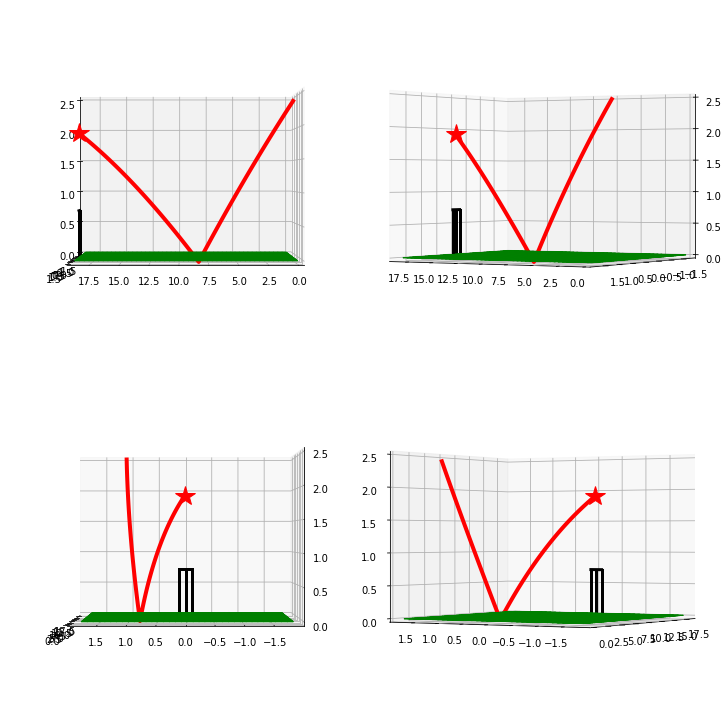

In [8]:
# Example of a 3d trajectory
speed = 140
release = 15
theta = 0
windspeed = [-5.0,-4,0]
bounce = 0.7
LDS = 1.0
SHD = 1.8
AL = 0.6

traj = ball_trajectory(speed,release,theta, windspeed, bounce,
            LDS, SHD, AL, history=True)

plot_3d_trajectory(traj)

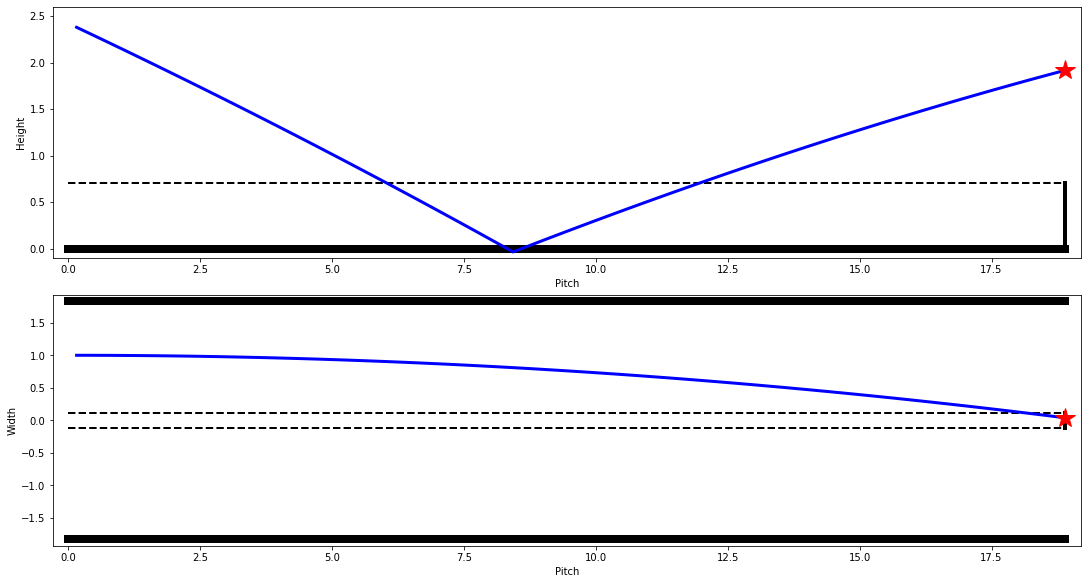

In [9]:
# Example of a 2d trajectory
speed = 160
release = 15
theta = 0
windspeed = [-5.0,-4,0]
bounce = 0.7
LDS = 1.0
SHD = 1.8
AL = 0.6

traj = ball_trajectory(speed,release,theta, windspeed, bounce,
            LDS, SHD, AL, history=True, dt = 0.005, max_itr=1000)

plot_2d_trajectory([traj])

In [10]:
def bowl(dt = 0.005, max_itr=1000):
    speed = 100.0 + (160.0 - 100.0)*np.random.random()
    release = 0.0 + (15.0 - 0.0)*np.random.random()
    theta = -15.0 + (15.0 + 15.0)*np.random.random()
    windspeed = [-5.0 + (5.0 + 5.0)*np.random.random(),
                 -5.0 + (5.0 + 5.0)*np.random.random(),
                 0.0]
    bounce = 0.6 + (0.8 - 0.6)*np.random.random()
    LDS = 0.3 + (1.5 - 0.3)*np.random.random()
    LDS = LDS if np.random.random() >= 0.5 else LDS*-1.0
    SHD = 1.4 + (1.9 - 1.4)*np.random.random()
    AL = 0.6 + (0.8 - 0.6)*np.random.random()
    
    traj = ball_trajectory(speed,release,theta, windspeed, bounce,
            LDS, SHD, AL, history=True, dt = dt, max_itr=max_itr)
    
    traj_len = len(traj)
    interception = 0.85 + (0.95 - 0.85)*np.random.random()
    
    interception_idx = int(traj_len*interception)
    intercepted_traj = traj[:interception_idx]
    return traj, intercepted_traj

def trajectory_toTensor(traj,step):
    traj = [traj[i].view(-1,3) for i in range(len(traj))]
    traj_tensor = torch.stack(traj)
    seq, value = [],[]
    for i in range(len(traj)-1):
        seq.append(traj_tensor[:step,:,:])
        value.append(traj_tensor[step,:,:])
        traj_tensor = traj_tensor[step+1:,:,:]
        if traj_tensor.shape[0] <= step:
            break
            
    seq_tensor = torch.stack(seq)
    value_tensor = torch.stack(value)
    return seq_tensor, value_tensor
        

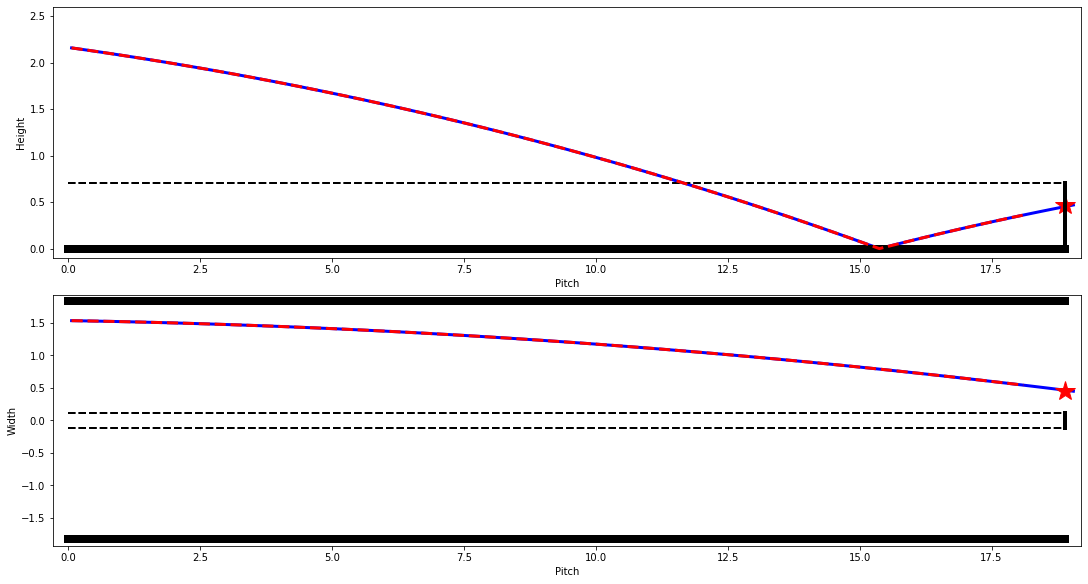

In [47]:
# randomized_bowling
plot_2d_trajectory(bowl())

In [12]:
traj,_ = bowl()
step = 3
traj = [traj[i].view(-1,3) for i in range(len(traj))]
seq_tensor, value_tensor = trajectory_toTensor(traj, step=3)

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        # x -> batch_size, seq, input_features
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out,_ = self.lstm(x, h0)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

hidden_size = 128
num_classes = 2
num_epochs = 2
learning_rate = 0.001
input_size = 3
num_layers = 2

model = RNN(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
def sigmoid(x, a=2.0):
  return 1.0/(1.0 + torch.exp(-a*x))

# Input: windspeed, pitch bounce
# Output: release angle, speed
class Bowl(torch.nn.Module):
  def __init__(self, n_hidden=10, scale=1.0):
    super(Bowl, self).__init__()
    self.n_hidden = n_hidden
    self.scale = scale
    self.layer1 = torch.nn.Linear(2, n_hidden)
    self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer3 = torch.nn.Linear(n_hidden, 2)
    self.act = torch.nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.act(x)
    x = self.layer2(x)
    x = self.act(x)
    x = self.layer3(x)
    x = sigmoid(x, self.scale) # To scale output to [0,1]
    return x

xs_wicket = torch.tensor(
    [L, 0.75*S], dtype=torch.float32
)
speed_lo = 100*kmph2mps
speed_hi = 160*kmph2mps
release_lo = 0.0*deg2rad
release_hi = 10.0*deg2rad

def loss_bowl(model, windspeed, bounce, dt):
  wb = torch.tensor(
      [windspeed, bounce], dtype=torch.float32, requires_grad=True
  )
  rs = model(wb)
  release = release_lo + (release_hi - release_lo)*rs[0]
  speed = speed_lo + (speed_hi - speed_lo)*rs[1]
  xs = get_position(release)
  vs = get_velocity(release, speed)
  xs = bowl(xs, vs, windspeed, bounce, dt)
  loss = 0.5*torch.norm(xs - xs_wicket)**2
  return loss 

def train_bowl(model, optimizer, windspeeds, bounces, dt):
  train_loss = 0.0
  for w, b in zip(windspeeds, bounces):
    optimizer.zero_grad()
    loss = loss_bowl(model, w, b, dt)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(windspeeds)
  return train_loss

NameError: name 'S' is not defined